## Evaluating quantum kernel matrices and solve a simple regression task

This notebook shows how to use sQUlearn to evaluate a fidelity quantum kernel (FQK)

$$
k(x,x')^Q = |\braket{\psi(x)|\psi(x')}|^2
$$

or a projected quantum kernel (PQK) of the form
$$
    k(x,x')^{PQ} = \exp\left(-\gamma\sum_k\sum_{P\in\lbrace X,Y,Z\rbrace}[\mathrm{tr}(P\varrho(x)_k) - \mathrm{tr}(P\varrho(x')_k)]^2\right) = \exp\left(-\gamma[\mathrm{QNN}(x) - \mathrm{QNN}(x')]^2\right)
$$
The quantum feature map/ parameterized quantum circuit to obtain both FQK and QNN is chosen to be the Chebyshev polynomial feature map. The trainable parameters of the quantum feature map are sampled randomly. The training kernel matrix is evaluated for a simple toy function and the corresponding regression task is solved using QKRR. Finally, the results are plotted and the MSE score is evaluated.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.primitives import Estimator
from squlearn.feature_map import ChebPQC
from squlearn.kernel.matrix import ProjectedQuantumKernel, FidelityKernel
from squlearn.kernel.ml import QKRR
from squlearn.util import Executor

In [3]:
# Generate data set (analogously to qgpr_workflow.ipynb example)
def func(x):
    return np.sin(3*x)*x*x

# define some noise that can be added to training data
noise_std = 0.1
x = np.linspace(-1, 1, 100)
y = func(x)
x_train = np.linspace(-1, 1, 15)
y_train = func(x_train) + np.random.normal(scale=noise_std, size=len(x_train))

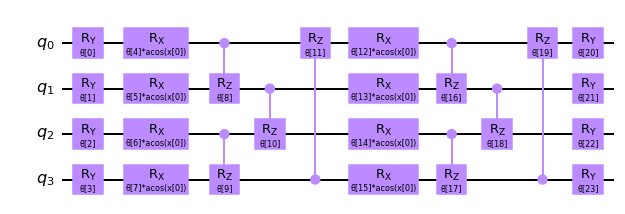

In [4]:
# set up feature map with trainable parameters being randomly initialized
fmap = ChebPQC(
    num_qubits=4, num_features=1, num_layers=2
)
fmap.draw()

In [5]:
# now we can define the kernel
# we can either use the ProjectedQuantumKernel or the FidelityKernel

# 1.Option: ProjectedQuantumKernel
q_kernel_pqk = ProjectedQuantumKernel(feature_map=fmap, executor=Executor(Estimator()),
                                      measurement='XYZ', outer_kernel='gaussian',
                                      gamma=2.0)

# 2.Option: FidelityKernel
q_kernel_fqk = FidelityKernel(feature_map=fmap, executor=Executor('statevector_simulator'))

In [6]:
# now we need to assign the free parameters of the feature map to the kernel
np.random.seed(0)
param = np.random.rand(fmap.num_parameters)
q_kernel_pqk.assign_parameters(param)
q_kernel_fqk.assign_parameters(param)

# now we can calculate the kernel matrix for given data
pqk_matrix = q_kernel_pqk.evaluate(x_train.reshape(-1, 1))
#print(pqk_matrix)
fqk_matrix = q_kernel_fqk.evaluate(x_train.reshape(-1, 1))
#print(fqk_matrix)

In [7]:
# now we can basically use any qml kernel method
# Example: QKRR 
qkrr_pqk = QKRR(quantum_kernel=q_kernel_pqk, alpha=1e-3)
qkrr_pqk.fit(x_train.reshape(-1, 1), y_train)
y_pred_pqk = qkrr_pqk.predict(x.reshape(-1, 1))

qkrr_fqk = QKRR(quantum_kernel=q_kernel_fqk, alpha=1e-3)
qkrr_fqk.fit(x_train.reshape(-1, 1), y_train)
y_pred_fqk = qkrr_fqk.predict(x.reshape(-1, 1))

MSE PQK KRR:  0.01530901240265024
MSE FQK KRR:  0.008356379602314216


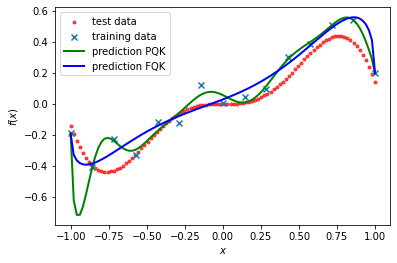

In [8]:
from sklearn.metrics import mean_squared_error
print("MSE PQK KRR: ", mean_squared_error(y, y_pred_pqk))
print("MSE FQK KRR: ", mean_squared_error(y, y_pred_fqk))

# Plot the results
# plot result
plt.scatter(x.reshape(-1,1), y, marker='.',label='test data', color='red', alpha=0.7)
plt.scatter(x_train, y_train, marker='x', label='training data')
plt.plot(x, y_pred_pqk, linewidth=2, color='green', label='prediction PQK')
plt.plot(x, y_pred_fqk, linewidth=2, c='b', label='prediction FQK')
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.show()